# Danny's Diner Case Study:

1. [What is the total amount each customer spent at the restaurant?](#1.-What-is-the-total-amount-each-customer-spent-at-the-restaurant?)<br/><br/>

2. [How many days has each customer visited the restaurant?](#2.-How-many-days-has-each-customer-visited-the-restaurant?)
<br/><br/>
3. [What was the first item from the menu purchased by each customer?](#3.-What-was-the-first-item-from-the-menu-purchased-by-each-customer?)
<br/><br/>
4. [What is the most purchased item on the menu and how many times was it purchased by all customers?](#4.-What-is-the-most-purchased-item-on-the-menu-and-how-many-times-was-it-purchased-by-all-customers?)
<br/><br/>
5. [Which item was the most popular for each customer?](#5.-Which-item-was-the-most-popular-for-each-customer?)
<br/><br/>
6. [Which item was purchased first by the customer after they became a member?](#6.-Which-item-was-purchased-first-by-the-customer-after-they-became-a-member?)
<br/><br/>
7. [Which item was purchased just before the customer became a member?](#7.-Which-item-was-purchased-just-before-the-customer-became-a-member?)
<br/><br/>
8. [What is the total items and amount spent for each member before they became a member?](#8.-What-is-the-total-items-and-amount-spent-for-each-member-before-they-became-a-member?)
<br/><br/>
9. [If each dollar 1 spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have?](#9.-If-each-dollar-1-spent-equates-to-10-points-and-sushi-has-a-2x-points-multiplier---how-many-points-would-each-customer-have?)
<br/><br/>
10. [In the first week after a customer joins the program (including their join date) they earn 2x points on all items, not just sushi - how many points do customer A and B have at the end of January?](#10.-In-the-first-week-after-a-customer-joins-the-program-(including-their-join-date)-they-earn-2x-points-on-all-items,-not-just-sushi---how-many-points-do-customer-A-and-B-have-at-the-end-of-January?)

## Raw data:

The dataset have 3 tables: sales, menu and members

### Entity Relationship Diagram

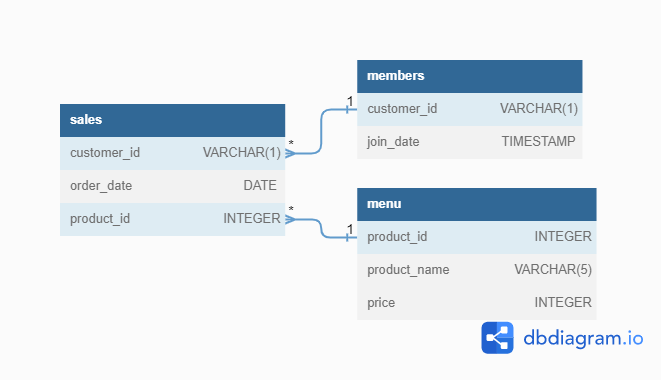

### Creating Tables

In [1]:
%reload_ext sql

In [2]:
%sql sqlite://

In [3]:
%%sql 
CREATE TABLE sales (
  "customer_id" VARCHAR(1),
  "order_date" DATE,
  "product_id" INTEGER
);

INSERT INTO sales
  ("customer_id", "order_date", "product_id")
VALUES
  ('A', '2021-01-01', '1'),
  ('A', '2021-01-01', '2'),
  ('A', '2021-01-07', '2'),
  ('A', '2021-01-10', '3'),
  ('A', '2021-01-11', '3'),
  ('A', '2021-01-11', '3'),
  ('B', '2021-01-01', '2'),
  ('B', '2021-01-02', '2'),
  ('B', '2021-01-04', '1'),
  ('B', '2021-01-11', '1'),
  ('B', '2021-01-16', '3'),
  ('B', '2021-02-01', '3'),
  ('C', '2021-01-01', '3'),
  ('C', '2021-01-01', '3'),
  ('C', '2021-01-07', '3');
 

CREATE TABLE menu (
  "product_id" INTEGER,
  "product_name" VARCHAR(5),
  "price" INTEGER
);

INSERT INTO menu
  ("product_id", "product_name", "price")
VALUES
  ('1', 'sushi', '10'),
  ('2', 'curry', '15'),
  ('3', 'ramen', '12');
  

CREATE TABLE members (
  "customer_id" VARCHAR(1),
  "join_date" DATE
);

INSERT INTO members
  ("customer_id", "join_date")
VALUES
  ('A', '2021-01-07'),
  ('B', '2021-01-09');


 * sqlite://
Done.
15 rows affected.
Done.
3 rows affected.
Done.
2 rows affected.


[]

[Back to top](#Danny's-Diner-Case-Study:)

## Solutions:

### 1. What is the total amount each customer spent at the restaurant?

In [10]:
%%sql

SELECT s.customer_id,
       Sum(m.price) AS amount_spent
FROM   sales s
       JOIN menu m
         ON s.product_id = m.product_id
GROUP  BY 1
ORDER  BY 1;

 * sqlite://
Done.


customer_id,amount_spent
A,76
B,74
C,36


[Back to top](#Danny's-Diner-Case-Study:)

### 2. How many days has each customer visited the restaurant?

In [15]:
%%sql

SELECT customer_id,
       Count(DISTINCT( order_date )) AS days_visited
FROM   sales
GROUP  BY 1
ORDER  BY 1

 * sqlite://
Done.


customer_id,days_visited
A,4
B,6
C,2


[Back to top](#Danny's-Diner-Case-Study:)

### 3. What was the first item from the menu purchased by each customer?
Item bought first by each customer on each day

In [35]:
%%sql

WITH sales_ranked
     AS (SELECT *,
                Row_number()
                  OVER(
                    partition BY customer_id, order_date
                    ORDER BY order_date) AS rank_order
         FROM   sales)
SELECT s.order_date,
       s.customer_id,
       m.product_name
FROM   sales_ranked s
       LEFT JOIN menu m
              ON s.product_id = m.product_id
WHERE  s.rank_order = 1
ORDER  BY 1,
          2 

 * sqlite://
Done.


order_date,customer_id,product_name
2021-01-01,A,sushi
2021-01-01,B,curry
2021-01-01,C,ramen
2021-01-02,B,curry
2021-01-04,B,sushi
2021-01-07,A,curry
2021-01-07,C,ramen
2021-01-10,A,ramen
2021-01-11,A,ramen
2021-01-11,B,sushi


[Back to top](#Danny's-Diner-Case-Study:)

### 4. What is the most purchased item on the menu and how many times was it purchased by all customers?
One should not use "order by 1 desc limit 1" since multiple items can be bought the most times.

In [43]:
%%sql

WITH items_bought
     AS (SELECT m.product_name,
                Count(s.product_id)                    AS times_bought,
                Rank()
                  OVER(
                    ORDER BY Count(s.product_id) DESC) AS rank
         FROM   sales s
                JOIN menu m
                  ON s.product_id = m.product_id
         GROUP  BY 1)
SELECT product_name,
       times_bought
FROM   items_bought
WHERE  rank = 1

 * sqlite://
Done.


product_name,times_bought
ramen,8


[Back to top](#Danny's-Diner-Case-Study:)

### 5. Which item was the most popular for each customer?
Most popular means most bought item by a customer

In [51]:
%%sql

WITH ranked_products_bought
     AS (SELECT s.customer_id,
                m.product_name,
                Count(s.product_id)                    AS times_bought,
                Rank()
                  OVER(
                    partition BY s.customer_id
                    ORDER BY Count(s.product_id) DESC) AS rank
         FROM   sales s
                LEFT JOIN menu m
                       ON s.product_id = m.product_id
         GROUP  BY 1,
                   2)
SELECT customer_id,
       product_name,
       times_bought
FROM   ranked_products_bought
WHERE  rank = 1
ORDER  BY 1;

 * sqlite://
Done.


customer_id,product_name,times_bought
A,ramen,3
B,sushi,2
B,ramen,2
B,curry,2
C,ramen,3


[Back to top](#Danny's-Diner-Case-Study:)

### 6. Which item was purchased first by the customer after they became a member?

In [59]:
%%sql

WITH ranked_items_bought
     AS (SELECT s.customer_id,
                m1.product_name,
                m.join_date,
                s.order_date,
                Rank()
                  OVER(
                    partition BY s.customer_id
                    ORDER BY order_date) AS rank
         FROM   sales s
                RIGHT JOIN members m
                        ON s.customer_id = m.customer_id
                           AND s.order_date >= m.join_date
                JOIN menu m1
                  ON s.product_id = m1.product_id)
SELECT customer_id,
       product_name,
       join_date,
       order_date
FROM   ranked_items_bought
WHERE  rank = 1

 * sqlite://
Done.


customer_id,product_name,join_date,order_date
A,curry,2021-01-07,2021-01-07
B,sushi,2021-01-09,2021-01-11


[Back to top](#Danny's-Diner-Case-Study:)

### 7. Which item was purchased just before the customer became a member?

In [65]:
%%sql

WITH ranked_items_bought
     AS (SELECT s.customer_id,
                m1.product_name,
                m.join_date,
                s.order_date,
                Rank()
                  OVER(
                    partition BY s.customer_id
                    ORDER BY order_date DESC) AS rank
         FROM   sales s
                RIGHT JOIN members m
                        ON s.customer_id = m.customer_id
                           AND s.order_date < m.join_date
                JOIN menu m1
                  ON s.product_id = m1.product_id)
SELECT customer_id,
       product_name,
       join_date,
       order_date
FROM   ranked_items_bought
WHERE  rank = 1 

 * sqlite://
Done.


customer_id,product_name,join_date,order_date
A,sushi,2021-01-07,2021-01-01
A,curry,2021-01-07,2021-01-01
B,sushi,2021-01-09,2021-01-04


[Back to top](#Danny's-Diner-Case-Study:)

### 8. What is the total items and amount spent for each member before they became a member?

In [67]:
%%sql

SELECT s.customer_id,
       Count(s.product_id) AS total_items,
       Sum(m1.price)       AS amount_spent
FROM   sales s
       RIGHT JOIN members m
               ON s.customer_id = m.customer_id
                  AND s.order_date < m.join_date
       JOIN menu m1
         ON s.product_id = m1.product_id
GROUP  BY 1

 * sqlite://
Done.


customer_id,total_items,amount_spent
A,2,25
B,3,40


[Back to top](#Danny's-Diner-Case-Study:)

### 9. If each dollar 1 spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have?

In [118]:
%%sql

SELECT s.customer_id,
       Sum(CASE
             WHEN m.product_name = "sushi" THEN m.price * 20
             ELSE m.price * 10
           END) AS total_points
FROM   sales s
       JOIN menu m
         ON s.product_id = m.product_id
GROUP  BY 1 

 * sqlite://
Done.


customer_id,total_points
A,860
B,940
C,360


[Back to top](#Danny's-Diner-Case-Study:)

### 10. In the first week after a customer joins the program (including their join date) they earn 2x points on all items, not just sushi - how many points do customer A and B have at the end of January?

In [117]:
%%sql

SELECT s.customer_id,
       Sum(CASE
             WHEN ( s.order_date BETWEEN join_date AND Date(join_date, '+6 days'
                                                       ) )
                   OR m1.product_name = "sushi" THEN m1.price * 20
             ELSE m1.price * 10
           END) AS total_points
FROM   sales s
       LEFT JOIN members m
              ON s.customer_id = m.customer_id
       JOIN menu m1
         ON s.product_id = m1.product_id
WHERE  s.customer_id IN ( "A", "B" )
       AND s.order_date <= '2021-01-31'
GROUP  BY 1

 * sqlite://
Done.


customer_id,total_points
A,1370
B,820


[Back to top](#Danny's-Diner-Case-Study:)